##### Set up the environment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from collections import namedtuple
%matplotlib inline

# Models
#### updateing
$du = \frac{(-\Delta u + R.I_t)}{\tau}dt$, $u_{new} = u +  du $

#### Threshhold
$ u(t) = \theta \implies \text{Fire + Rest } (u = u_{rest}) $

## Leaky Integrate & Fire Model
#### formulate
$\tau.\frac{du}{dt} = -(u - u_{rest}) + R.I(t)$, $\Delta u = u - u_{rest}$ ,$I_t = I(t)$

In [2]:
class LIF:
    def __init__(self, config: namedtuple):
        self.τ = config.tau
        self.θ = config.threshold
        self.R = config.resistor
        self.u_rest = config.uRest
        self.dt = config.dt
        
        self.u = self.u_rest
        self.spike_trace = []
        
    def integrate(self, It, t):
        self.u += self.update(It)
        if self.u >= self.θ:
            self.u = self.u_rest
            self.spike_trace.append(t)
        return self.u
        
    def update(self, It):
        return self.right_hand_side(It) * (self.dt / self.τ) 
    
    def right_hand_side(self, It):
        return -(self.u - self.u_rest) + self.R * It
    
 

## Exponential Leaky Integrate & Fire Model
#### formulate
$\tau.\frac{du}{dt} = -(u - u_{rest}) + R.I(t) + \Delta_{T}exp(\frac{u - \theta_{rh}}{\Delta_{T}})$

$\Delta_{T}$ is the sharpness parameter.

$\theta_{rh}$ is the firing threshold.

In [3]:
class ELIF:
    def __init__(self, config: namedtuple):
        self.τ = config.tau
        self.θ = config.threshold
        self.R = config.resistor
        self.u_rest = config.uRest
        self.dt = config.dt
        self.ΔT = config.DeltaT
        
        self.u = self.u_rest
        self.spike_trace = []
        
    def integrate(self, It, t):
        self.u += self.update(It)
        if self.u >= self.θ:
            self.u = self.u_rest
            self.spike_trace.append(t)
        return self.u
        
    def update(self, It):
        return self.right_hand_side(It) * (self.dt / self.τ) 
    
    def right_hand_side(self, It):
        return -(self.u - self.u_rest) + self.R * It + self.ΔT * math.exp((self.u - self.θ)/self.ΔT)


## Addaptive Exponential Leaky Integrate & Fire Model
#### formulate
$\tau.\frac{du}{dt} = -(u - u_{rest}) + R.I(t) + \Delta_{T}exp(\frac{u - \theta_{rh}}{\Delta_{T}}) - Rw$

$\tau.\frac{dw}{dt} = a(u - u_{rest}) - w + b \tau_w \sum\limits_{t^f}\sigma(t - t^f)$

- At each threshold crossing, the adaptation variable w is increased by an amount b
- Adaptation is characterized by two parameters:
    - the parameter a is the source of subthreshold adaptation, because it couples adaptation to the voltage
    - spike-triggered adaptation is controlled by a combination of a and b.

In [4]:
class AELIF:
    def __init__(self, config: namedtuple):
        self.τm = config.tauM
        self.θ = config.threshold
        self.R = config.resistor
        self.u_rest = config.uRest
        self.dt = config.dt
        self.ΔT = config.DeltaT
        self.a = config.a
        self.b = config.b
        self.w = config.w
        self.τw = config.tauW
        
        self.u = self.u_rest
        self.spike_trace = []
        
    def integrate(self, It, t):
        self.u += self.update(It)
        self.w += self.update_w(t)
        
        if self.u >= self.θ:
            self.u = self.u_rest
            self.spike_trace.append(t)
        return self.u
        
    def update(self, It):
        return self.right_hand_side(It) * (self.dt / self.τm) 
    
    def update_w(self, t):
        return self.a * (self.u - self.u_rest) - self.w + self.b * self.τw * self.spike_trace.count(t)
    
    def right_hand_side(self, It):
        return -(self.u - self.u_rest) + self.R * (It - self.w) + self.ΔT * math.exp((self.u - self.θ) / self.ΔT)
                                                                          

### Configs

```python
params_creator.get('LIF')  = namedtuple('LIFParams', 'dt resistor tau threshold uRest')
params_creator.get('ELIF') = namedtuple('ELIFParams', 'DeltaT dt resistor tau threshold uRest'),
params_creator.get('AELIF') = namedtuple('AdaptiveELIFParams', 'DeltaT a b dt resistor tauM tauW threshold uRest w'),
params_creator.get('Env') = namedtuple('Enviroment', 'current_variation currents_params time_window')
```

In [5]:
params_creator = {
    'LIF': namedtuple('LIFParams', 'dt resistor tau threshold uRest'),
    'ELIF': namedtuple('ELIFParams', 'DeltaT dt resistor tau threshold uRest'),
    'AELIF': namedtuple('AdaptiveELIFParams', 'DeltaT a b dt resistor tauM tauW threshold uRest w'),
    'Env': namedtuple('Enviroment', 'current_variation currents_params time_window')
}

### Plotters

In [6]:
def plot_fi_curve(spike_trace, time_window, currents):
    frequencies = [len(spikes) / time_window for spikes in spike_trace]
    plt.plot(currents, frequencies, 'r')
    plt.xlabel(xlabel='I(t)')
    plt.ylabel(ylabel='f = 1/T')
    plt.title("frequency-current relation")
    plt.show()

In [7]:
def plot_firing_pattern(plotter, params):
    fig, axs = plt.subplots(2)
    axs[0].plot(plotter['times'], plotter['potentials'], 'g-')
    axs[0].plot(plotter['times'], [params.uRest] * len(plotter['times']), 'k--')
    axs[0].plot(plotter['times'], [params.threshold] * len(plotter['times']), 'b--')
    axs[0].set(xlabel='time', ylabel='u (t)')

    axs[1].plot(plotter['times'], plotter['currents'], 'b-')
    axs[1].set(xlabel='time', ylabel='I (t)')
    for ax in axs.flat:
        ax.label_outer()
    plt.show()

### Constant Current

In [8]:
class CurrentManager:
    def __init__(self, start, stop, step):
        self.arrange_params = (start, stop, step)
        self.currents = None
    def __enter__(self):
        self.currents = np.arange(*self.arrange_params)
        return self.currents
    def __exit__(self, type, value, traceback):
        del self.currents

In [9]:
def constant_current(Model, model_params, env):
    with CurrentManager(*env.currents_params) as currents:
            spike_trace = []
            for current in currents:
                plotter = { "potentials": [], "currents": [], "times": [] } 
                model = Model(model_params) # Model
                # time sequences
                starting_t = 0
                time_intervals = np.arange(starting_t, starting_t + env.time_window, model_params.dt)
                # integrations
                for t in time_intervals:
                    u = model.integrate(current, t)
                    plotter['potentials'].append(u)
                    plotter['currents'].append(current)                
                    plotter['times'].append(t)
                spike_trace.append(model.spike_trace)
                # Firing pattern
                plot_firing_pattern(plotter, model_params)
            plot_fi_curve(spike_trace, env.time_window, currents)

In [10]:
def noisy_current(Model, model_params, env):
    with CurrentManager(*env.currents_params) as currents:
            for current in currents:
                plotter = { "potentials": [], "currents": [], "times": [] } 
                model = Model(model_params) # Model
                # time sequences
                starting_t = 0
                time_intervals = np.arange(starting_t, starting_t + env.time_window, model_params.dt)
                # integrations
                for t in time_intervals:
                    It = current + np.random.uniform(*env.current_variation)
                    u = model.integrate(It, t)
                    plotter['potentials'].append(u)
                    plotter['currents'].append(It)                
                    plotter['times'].append(t)
                # Firing pattern
                plot_firing_pattern(plotter, model_params)

#### Enviroments Parameters
current_variation = (lower, uperbound) for noise value 

currents_params = (start, stop, step)

time_window = interval gap

In [11]:
# current_variation currents_params time_window
env = params_creator.get('Env')((-1,1), (0, 50, 5), 10)

#### Leaky Integrate & Fire Model Parameters

In [12]:
# 'dt resistor tau threshold uRest'
lif_params = [
    params_creator.get('LIF')(0.01, 10, 10, -50, -70),
    params_creator.get('LIF')(0.01, 10, 5, -50, -70), # τ = 5
    params_creator.get('LIF')(0.01, 10, 20, -50, -70), # τ = 20
    params_creator.get('LIF')(0.01, 20, 10, -50, -70), # R = 20
    params_creator.get('LIF')(0.01, 10, 10, -20, -70), # threshhold = -20
    params_creator.get('LIF')(0.01, random.random()*10, random.random()*10, -20, -70), # Random

]

#### Exponential Leaky Integrate & Fire Model Parameters

In [13]:
# DeltaT dt resistor tau threshold uRest
elif_params = [
     params_creator.get('ELIF')(1, 0.01, 10, 10, -50, -70),
     params_creator.get('ELIF')(1, 0.01, 10, 20, -50, -70), # τ = 20
     params_creator.get('ELIF')(5, 0.01,  5, 10, -50, -65), # delta_t = 5, r = 5, uRest=-65
     params_creator.get('ELIF')(2, 0.01, 10, 5, -55, -70), # τ = 20, threshhold=-55
     params_creator.get('ELIF')(1, 0.1, 10, 15, -50, -70),  # τ = 15, dt=0.1
     params_creator.get('ELIF')(random.random()*1, 0.1, random.random()*10, random.random()*15, -50, -70), # Random
]

#### Adaptive Exponential Leaky Integrate & Fire Model Parameters

In [14]:
# DeltaT a b dt resistor tauM tauW threshold uRest w
aelif_params = [
     params_creator.get('AELIF')(1, 1, 0.5, 0.01, 10, 5, 5, -50, -70, 2),
     params_creator.get('AELIF')(5, 0.2, 0.5, 0.01, 10, 5, 5, -50, -70, 2),
     params_creator.get('AELIF')(1, 1, 0.5, 0.01, 10, 10, 5, -50, -70, 0.2),
     params_creator.get('AELIF')(1, 1, 0.5, 0.01, 10, 5, 15, -50, -70, 2),
     params_creator.get('AELIF')(1, 1, 1.5, 0.01, 5, 5, 10, -50, -70, 2),
     params_creator.get('AELIF')(1, 1, random.random(), 0.01, random.random()*10, random.random()*5, random.random()*5, -50, -70, 2),
]

In [15]:
config_number = 5
assert 0 <= config_number <= min([len(lif_params), len(elif_params), len(aelif_params)]), 'config_number is not in acceptable range'
print(lif_params[config_number])
print(elif_params[config_number])
print(aelif_params[config_number])

LIFParams(dt=0.01, resistor=6.860183890424678, tau=5.348501572337925, threshold=-20, uRest=-70)
ELIFParams(DeltaT=0.6090238641467028, dt=0.1, resistor=9.531225804197684, tau=11.203724854843946, threshold=-50, uRest=-70)
AdaptiveELIFParams(DeltaT=1, a=1, b=0.12632452896941593, dt=0.01, resistor=4.984742832991298, tauM=2.071660679570093, tauW=3.2659915390744887, threshold=-50, uRest=-70, w=2)


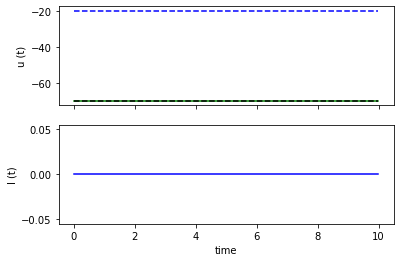

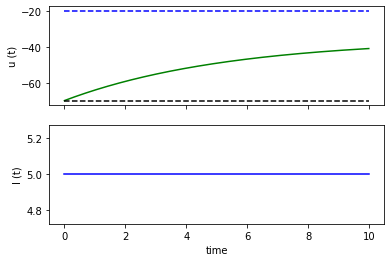

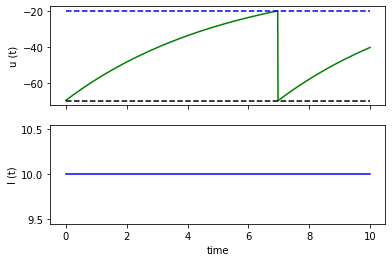

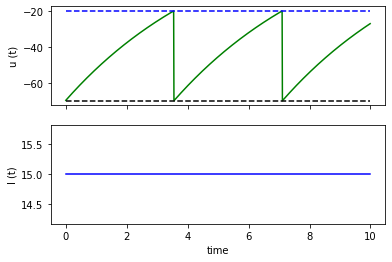

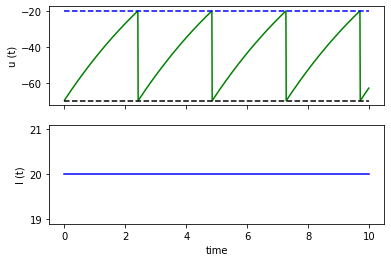

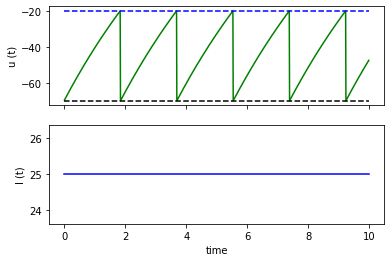

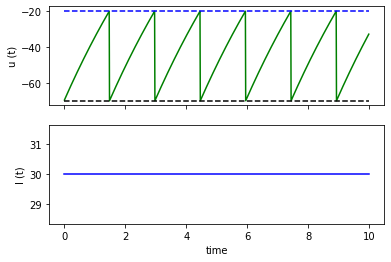

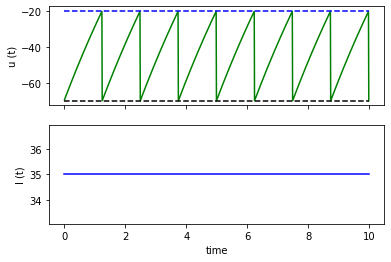

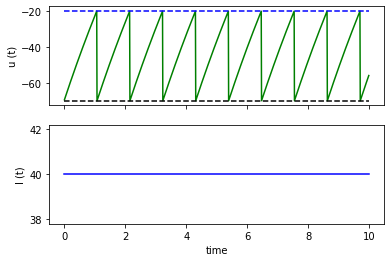

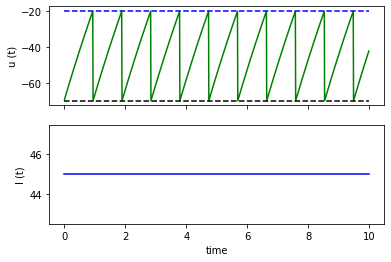

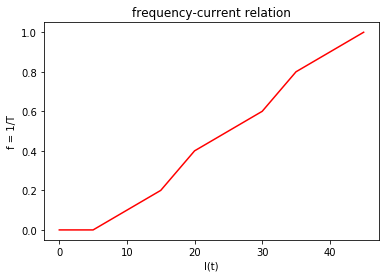

In [16]:
constant_current(LIF, lif_params[config_number], env)

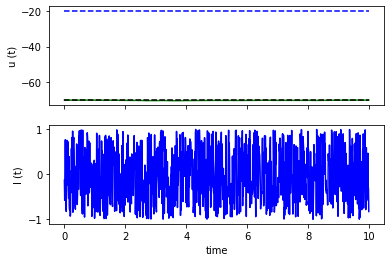

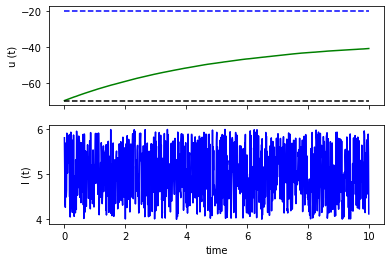

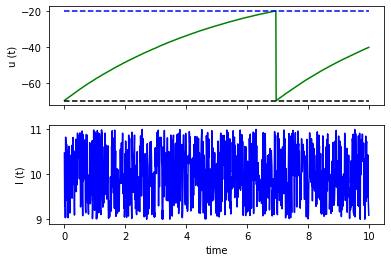

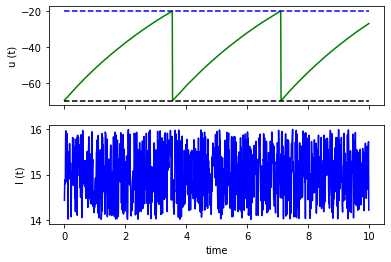

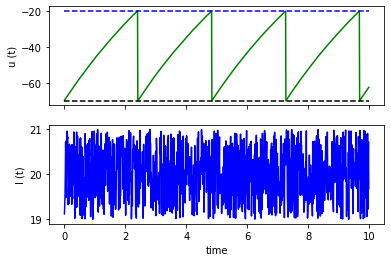

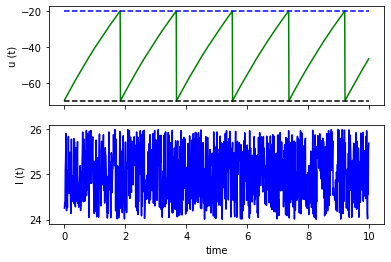

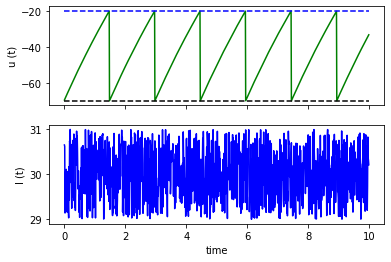

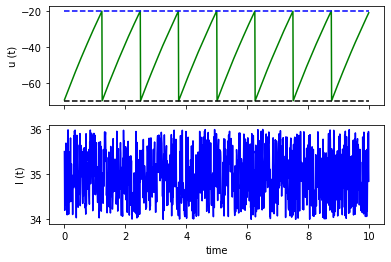

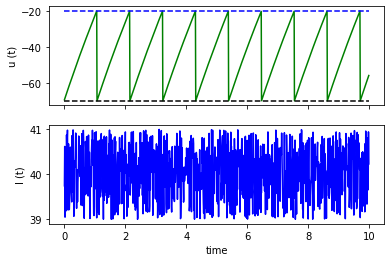

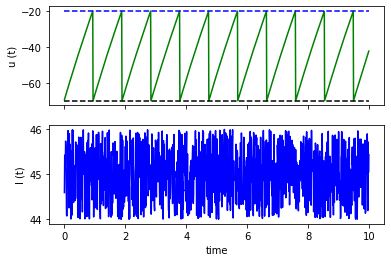

In [17]:
noisy_current(LIF, lif_params[config_number], env)

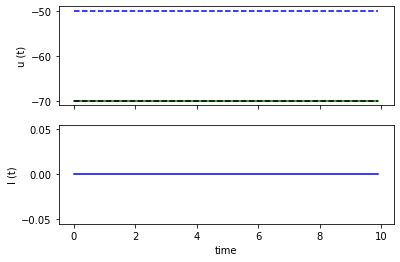

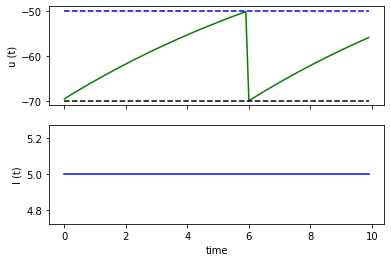

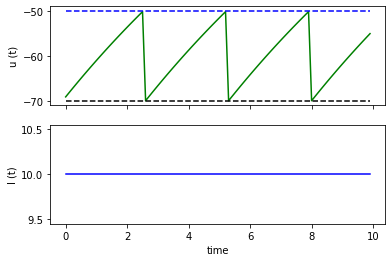

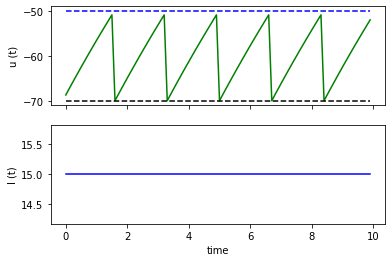

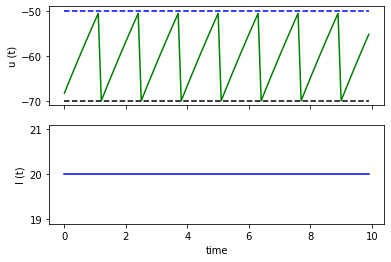

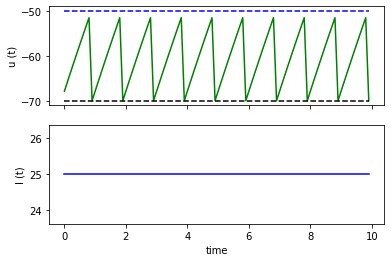

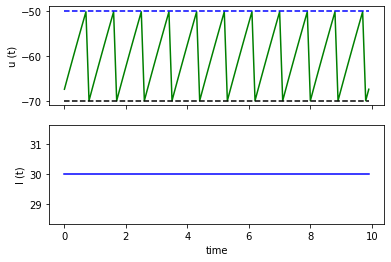

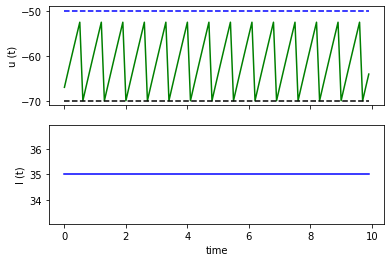

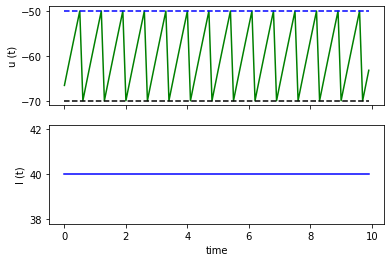

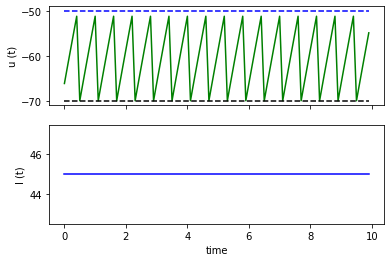

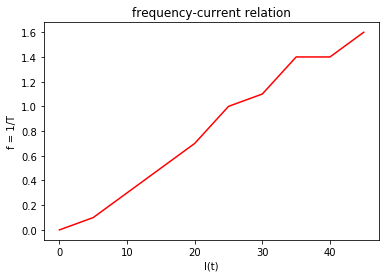

In [18]:
constant_current(ELIF, elif_params[config_number], env)

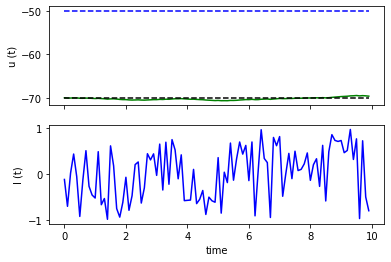

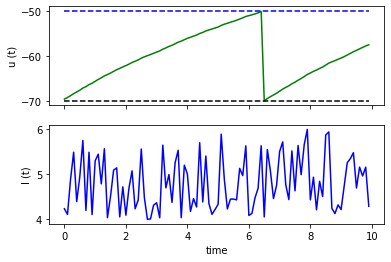

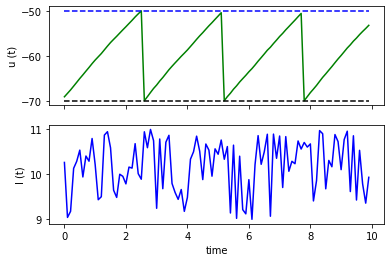

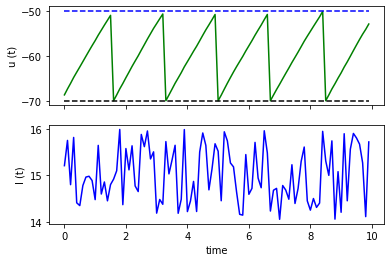

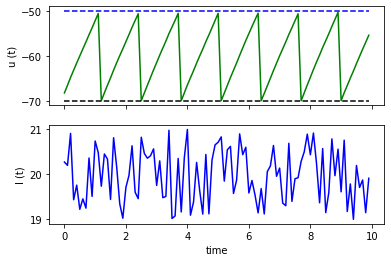

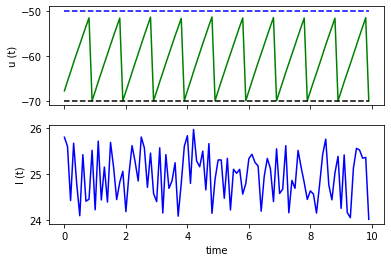

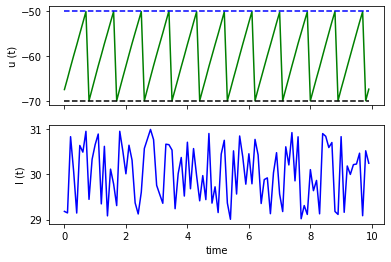

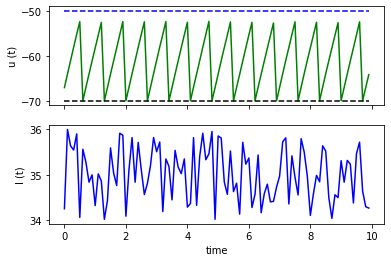

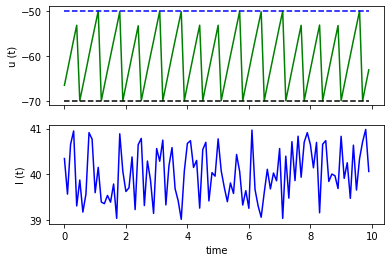

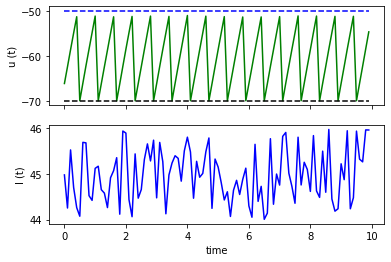

In [19]:
noisy_current(ELIF, elif_params[config_number], env)

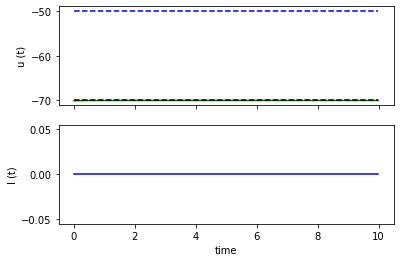

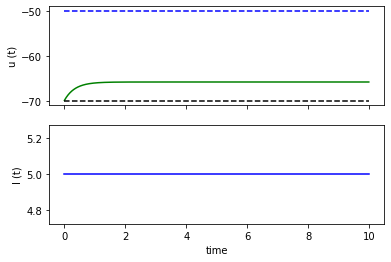

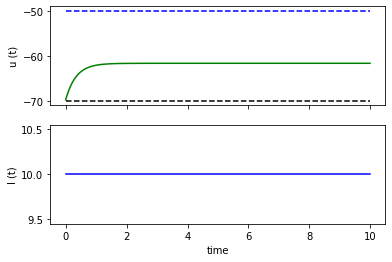

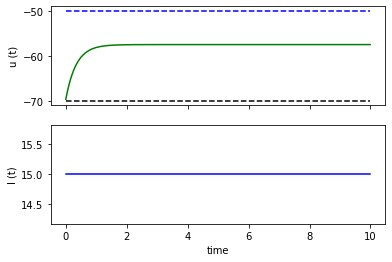

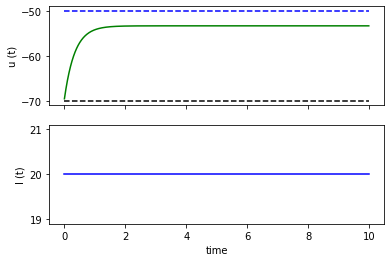

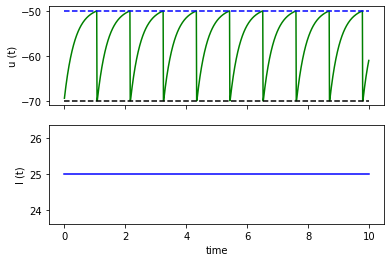

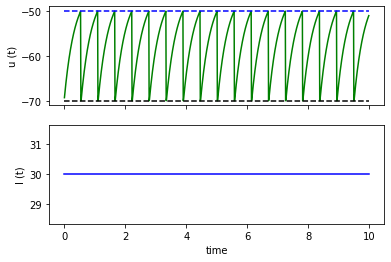

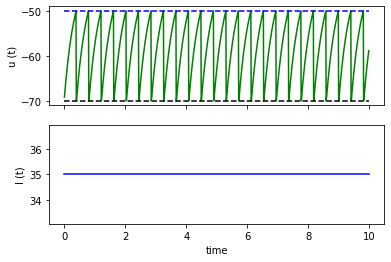

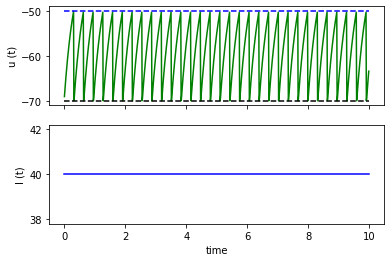

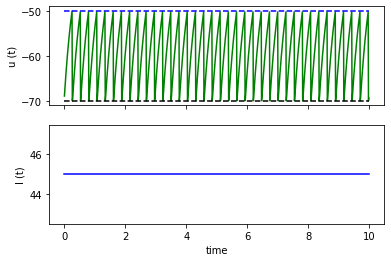

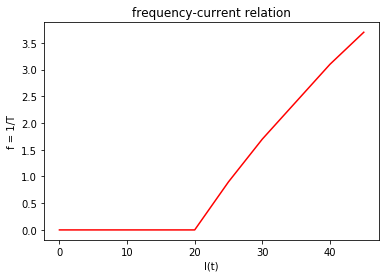

In [20]:
constant_current(AELIF, aelif_params[config_number], env)

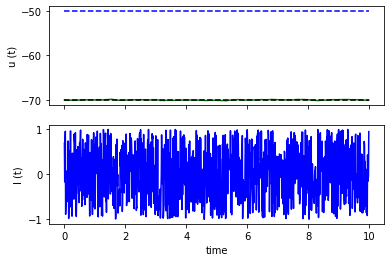

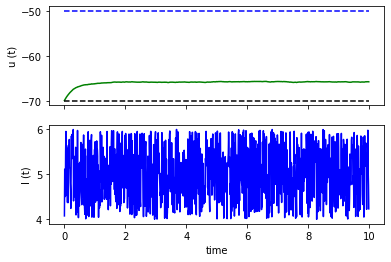

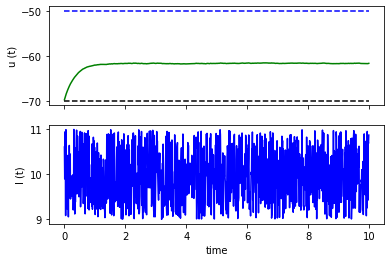

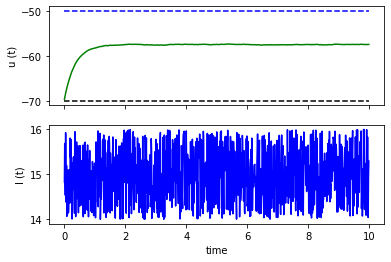

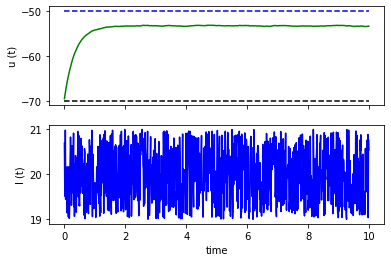

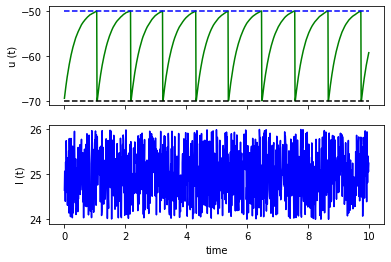

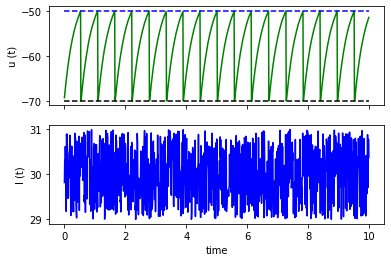

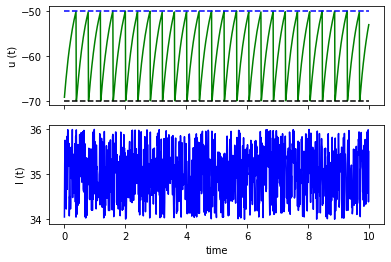

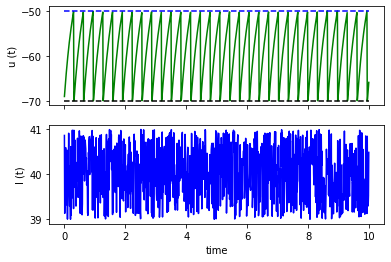

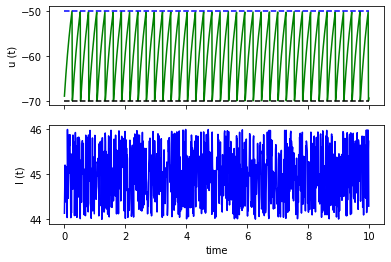

In [21]:
noisy_current(AELIF, aelif_params[config_number], env)